# Exploring and Clustering the Neighborhoods

In [70]:
%store -r neighborhoods

In [71]:
neighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


### Installing all the required libraries

In [3]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  54.25 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  35.90 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  40.53 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  48.42 MB/s
Libraries imported.


In [72]:
###Considering only neighborhoods with Toronto Borough
neighborhoods1 = neighborhoods[neighborhoods.Borough.str.contains('Toronto')].reset_index(drop=True)
neighborhoods1.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
1,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
2,M5B,Downtown Toronto,Ryerson,43.657162,-79.378937
3,M5B,Downtown Toronto,Garden District,43.657162,-79.378937
4,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418


### Setting up latitude and longitude of Toronoto

In [73]:
latitude = 43.6532
longitude = -79.3832

### Creating Map

In [74]:
# Creating a map
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)
map_toronto

In [75]:
for lat, lng, label in zip(neighborhoods1['Latitude'], neighborhoods1['Longitude'], neighborhoods1['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Define Foursquare Credentials and Version

In [76]:
# The code was removed by Watson Studio for sharing.

### Explore the first neighborhood

In [77]:
neighborhoods1.loc[0,'Neighborhood']

'Harbourfront'

In [78]:
#Get the lat long values of the neighbourhood
neighborhood_latitude = neighborhoods1.loc[0, 'Latitude'] 
neighborhood_longitude = neighborhoods1.loc[0, 'Longitude'] 

In [79]:
###Getting the top 100 venues within 500 metres radius

limit = 100
radius = 500

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    limit)
url 

'https://api.foursquare.com/v2/venues/explore?&client_id=NOL1IFHCN4TAEIL4BUWRQY0SFYC2TWTDUNOHC23YKFL5HJ1I&client_secret=1ZBK5ZR1B1EZOWLIOISYWQFLNYBGC1GOB4EO5NU1HFQLHKVG&v=20180212&ll=43.6542599,-79.3606359&radius=500&limit=100'

In [80]:
import requests
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c6925371ed2196e432eabaa'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-54ea41ad498e9a11e9e13308-0',
      'venue': {'beenHere': {'count': 0,
        'lastCheckinExpiredAt': 0,
        'marked': False,
        'unconfirmedCount': 0},
       'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d16a941735',
         'name': 'Bakery',
         'pluralName': 'Bakeries',
         'primary': True,
         'shortName': 'Bakery'}],
       'contact': {},
       'hereNow': {'count': 0, 'groups': [], 'summary': 'Nobody here'},
       'id': '54ea41ad498e9a11e9e13308',
       'location': {'address': '362 King St E',
        'cc': 'CA',
        'city': 'Toronto',
        'country': 'Canada',
   

In [81]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [82]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Toronto Cooper Koo Family Cherry St YMCA Centre,Gym / Fitness Center,43.653191,-79.357947
3,Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149
4,Body Blitz Spa East,Spa,43.654735,-79.359874


In [83]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

47 venues were returned by Foursquare.


## Explore Neighborhoods in Toronto

In [84]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [85]:
Toronto_venues = pd.DataFrame(getNearbyVenues(names=neighborhoods1['Neighborhood'],
                                   latitudes=neighborhoods1['Latitude'],
                                   longitudes=neighborhoods1['Longitude']
                                  ))

Harbourfront
Regent Park
Ryerson
Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Adelaide
King
Richmond
Dovercourt Village
Dufferin
Harbourfront East
Toronto Islands
Union Station
Little Portugal
Trinity
The Danforth West
Riverdale
Design Exchange
Toronto Dominion Centre
Brockton
Exhibition Place
Parkdale Village
The Beaches West
India Bazaar
Commerce Court
Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North
Forest Hill West
High Park
The Junction South
North Toronto West
The Annex
North Midtown
Yorkville
Parkdale
Roncesvalles
Davisville
Harbord
University of Toronto
Runnymede
Swansea
Moore Park
Summerhill East
Chinatown
Grange Park
Kensington Market
Deer Park
Forest Hill SE
Rathnelly
South Hill
Summerhill West
CN Tower
Bathurst Quay
Island airport
Harbourfront West
King and Spadina
Railway Lands
South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown
St. James Town
First Canadian Place
Underground city


In [86]:
print(Toronto_venues.shape)
Toronto_venues.head()

(3298, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Harbourfront,43.65426,-79.360636,Toronto Cooper Koo Family Cherry St YMCA Centre,43.653191,-79.357947,Gym / Fitness Center
3,Harbourfront,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
4,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [87]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adelaide,100,100,100,100,100,100
Bathurst Quay,14,14,14,14,14,14
Berczy Park,56,56,56,56,56,56
Brockton,18,18,18,18,18,18
Business Reply Mail Processing Centre 969 Eastern,18,18,18,18,18,18
CN Tower,14,14,14,14,14,14
Cabbagetown,48,48,48,48,48,48
Central Bay Street,82,82,82,82,82,82
Chinatown,100,100,100,100,100,100


In [88]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 242 uniques categories.


### Analyze Each Neighborhood

In [89]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Harbourfront,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [90]:
Toronto_onehot.shape

(3298, 242)

In [91]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,Adelaide,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.00,0.00,0.010000,0.010000,0.000000,0.030000,0.0000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.030000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.01,0.020000,0.000000,0.000000,0.01,0.020000,0.010000,0.00,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.010000,0.060000,0.000000,0.000000,0.00,0.000000,0.000000,0.020

In [92]:
Toronto_grouped.shape

(73, 242)

In [93]:
num_top_venues = 5

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide----
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.05
2           Steakhouse  0.04
3      Thai Restaurant  0.04
4  American Restaurant  0.04


----Bathurst Quay----
              venue  freq
0    Airport Lounge  0.14
1   Airport Service  0.14
2  Airport Terminal  0.14
3     Boat or Ferry  0.07
4          Boutique  0.07


----Berczy Park----
            venue  freq
0     Coffee Shop  0.07
1    Cocktail Bar  0.05
2      Restaurant  0.05
3             Pub  0.04
4  Farmers Market  0.04


----Brockton----
                   venue  freq
0         Breakfast Spot  0.11
1                   Café  0.11
2            Coffee Shop  0.11
3           Climbing Gym  0.06
4  Performing Arts Venue  0.06


----Business Reply Mail Processing Centre 969 Eastern----
                venue  freq
0  Light Rail Station  0.11
1         Yoga Studio  0.06
2       Auto Workshop  0.06
3          Comic Shop  0.06
4                Park  0.06


----CN Tower----
           

In [94]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [95]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,American Restaurant,Steakhouse,Thai Restaurant,Clothing Store,Asian Restaurant,Restaurant,Hotel,Bar
1,Bathurst Quay,Airport Lounge,Airport Terminal,Airport Service,Boutique,Sculpture Garden,Boat or Ferry,Plane,Airport Gate,Airport Food Court,Airport
2,Berczy Park,Coffee Shop,Restaurant,Cocktail Bar,Cheese Shop,Café,Pub,Farmers Market,Steakhouse,Italian Restaurant,Bakery
3,Brockton,Coffee Shop,Breakfast Spot,Café,Pet Store,Burrito Place,Stadium,Bar,Caribbean Restaurant,Italian Restaurant,Climbing Gym
4,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Park,Comic Shop,Recording Studio


### Looking at the elbow method for an optimal k

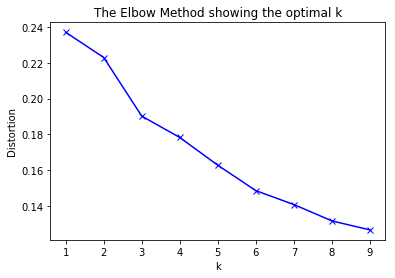

In [99]:
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(Toronto_grouped_clustering)
    kmeanModel.fit(Toronto_grouped_clustering)
    distortions.append(sum(np.min(cdist(Toronto_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / Toronto_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Clustering Neighborhoods

In [100]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 2, 1, 4, 4, 2, 1, 1, 4, 4], dtype=int32)

In [101]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'CCluster Labels', kmeans.labels_)

Toronto_merged = neighborhoods1

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,CCluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,1,Coffee Shop,Café,Bakery,Park,Pub,Mexican Restaurant,Breakfast Spot,Theater,Chocolate Shop,Spa
1,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636,1,Coffee Shop,Café,Bakery,Park,Pub,Mexican Restaurant,Breakfast Spot,Theater,Chocolate Shop,Spa
2,M5B,Downtown Toronto,Ryerson,43.657162,-79.378937,1,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Middle Eastern Restaurant,Thai Restaurant,Theater,Japanese Restaurant,Pizza Place,Plaza
3,M5B,Downtown Toronto,Garden District,43.657162,-79.378937,1,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Middle Eastern Restaurant,Thai Restaurant,Theater,Japanese Restaurant,Pizza Place,Plaza
4,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Restaurant,Café,Hotel,Bakery,Italian Restaurant,Pizza Place,Gastropub,Clothing Store,Breakfast Spot


In [102]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['CCluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

In [104]:
# Cluster 1
Toronto_merged.loc[Toronto_merged['CCluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,CCluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Central Toronto,0,Garden,Women's Store,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


In [105]:
# Cluser 2
Toronto_merged.loc[Toronto_merged['CCluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,CCluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,1,Coffee Shop,Café,Bakery,Park,Pub,Mexican Restaurant,Breakfast Spot,Theater,Chocolate Shop,Spa
1,Downtown Toronto,1,Coffee Shop,Café,Bakery,Park,Pub,Mexican Restaurant,Breakfast Spot,Theater,Chocolate Shop,Spa
2,Downtown Toronto,1,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Middle Eastern Restaurant,Thai Restaurant,Theater,Japanese Restaurant,Pizza Place,Plaza
3,Downtown Toronto,1,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Middle Eastern Restaurant,Thai Restaurant,Theater,Japanese Restaurant,Pizza Place,Plaza
4,Downtown Toronto,1,Coffee Shop,Restaurant,Café,Hotel,Bakery,Italian Restaurant,Pizza Place,Gastropub,Clothing Store,Breakfast Spot
5,East Toronto,1,Coffee Shop,Pub,Burger Joint,Women's Store,Discount Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
6,Downtown Toronto,1,Coffee Shop,Restaurant,Cocktail Bar,Cheese Shop,Café,Pub,Farmers Market,Steakhouse,Italian Restaurant,Bakery
7,Downtown Toronto,1,Coffee Shop,Café,Italian Restaurant,Burger Joint,Bar,Chinese Restaurant,Spa,Thai Restaurant,Sandwich Place,Indian Restaurant
14,Downtown Toronto,1,Coffee Shop,Hotel,Aquarium,Pizza Place,Café,Italian Restaurant,Bakery,Brewery,Restaurant,Scenic Lookout
15,Downtown Toronto,1,Coffee Shop,Hotel,Aquarium,Pizza Place,Café,Italian Restaurant,Bakery,Brewery,Restaurant,Scenic Lookout


In [106]:
# Cluster 3
Toronto_merged.loc[Toronto_merged['CCluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,CCluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
59,Downtown Toronto,2,Airport Lounge,Airport Terminal,Airport Service,Boutique,Sculpture Garden,Boat or Ferry,Plane,Airport Gate,Airport Food Court,Airport
60,Downtown Toronto,2,Airport Lounge,Airport Terminal,Airport Service,Boutique,Sculpture Garden,Boat or Ferry,Plane,Airport Gate,Airport Food Court,Airport
61,Downtown Toronto,2,Airport Lounge,Airport Terminal,Airport Service,Boutique,Sculpture Garden,Boat or Ferry,Plane,Airport Gate,Airport Food Court,Airport
62,Downtown Toronto,2,Airport Lounge,Airport Terminal,Airport Service,Boutique,Sculpture Garden,Boat or Ferry,Plane,Airport Gate,Airport Food Court,Airport
63,Downtown Toronto,2,Airport Lounge,Airport Terminal,Airport Service,Boutique,Sculpture Garden,Boat or Ferry,Plane,Airport Gate,Airport Food Court,Airport
64,Downtown Toronto,2,Airport Lounge,Airport Terminal,Airport Service,Boutique,Sculpture Garden,Boat or Ferry,Plane,Airport Gate,Airport Food Court,Airport
65,Downtown Toronto,2,Airport Lounge,Airport Terminal,Airport Service,Boutique,Sculpture Garden,Boat or Ferry,Plane,Airport Gate,Airport Food Court,Airport


In [107]:
#Cluser 4
Toronto_merged.loc[Toronto_merged['CCluster Labels'] == 3, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,CCluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
49,Central Toronto,3,Playground,Gym,Trail,Tennis Court,Women's Store,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop
50,Central Toronto,3,Playground,Gym,Trail,Tennis Court,Women's Store,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop


In [108]:
# Cluster 5
Toronto_merged.loc[Toronto_merged['CCluster Labels'] == 4, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,CCluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Downtown Toronto,4,Café,Grocery Store,Park,Baby Store,Diner,Athletics & Sports,Italian Restaurant,Nightclub,Restaurant,Coffee Shop
9,Downtown Toronto,4,Coffee Shop,Café,American Restaurant,Steakhouse,Thai Restaurant,Clothing Store,Asian Restaurant,Restaurant,Hotel,Bar
10,Downtown Toronto,4,Coffee Shop,Café,American Restaurant,Steakhouse,Thai Restaurant,Clothing Store,Asian Restaurant,Restaurant,Hotel,Bar
11,Downtown Toronto,4,Coffee Shop,Café,American Restaurant,Steakhouse,Thai Restaurant,Clothing Store,Asian Restaurant,Restaurant,Hotel,Bar
12,West Toronto,4,Supermarket,Pharmacy,Discount Store,Bakery,Gym / Fitness Center,Park,Pool,Music Venue,Café,Middle Eastern Restaurant
13,West Toronto,4,Supermarket,Pharmacy,Discount Store,Bakery,Gym / Fitness Center,Park,Pool,Music Venue,Café,Middle Eastern Restaurant
17,West Toronto,4,Bar,Men's Store,Restaurant,Asian Restaurant,Coffee Shop,Pizza Place,Bakery,Vietnamese Restaurant,Café,Cocktail Bar
18,West Toronto,4,Bar,Men's Store,Restaurant,Asian Restaurant,Coffee Shop,Pizza Place,Bakery,Vietnamese Restaurant,Café,Cocktail Bar
23,West Toronto,4,Coffee Shop,Breakfast Spot,Café,Pet Store,Burrito Place,Stadium,Bar,Caribbean Restaurant,Italian Restaurant,Climbing Gym
24,West Toronto,4,Coffee Shop,Breakfast Spot,Café,Pet Store,Burrito Place,Stadium,Bar,Caribbean Restaurant,Italian Restaurant,Climbing Gym


In [109]:
# Cluster 6
Toronto_merged.loc[Toronto_merged['CCluster Labels'] == 5, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,CCluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,Central Toronto,5,Jewelry Store,Sushi Restaurant,Park,Trail,Women's Store,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Electronics Store
35,Central Toronto,5,Jewelry Store,Sushi Restaurant,Park,Trail,Women's Store,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Electronics Store
66,Downtown Toronto,5,Park,Playground,Trail,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Women's Store
